In [24]:
from scipy.stats import median_abs_deviation

import sys
sys.path.insert(0, '/home/workspace/mm_analysis')
sys.path.insert(0, '/home/workspace/')

from py_util import *
from utilities import *

hdir = '/home/workspace'
wdir = hdir + "/mm_analysis/EXP-01244"
objdir = wdir + "/processing/objects/"
degdir = wdir + "/deg_list/"

adata = sc.read_h5ad(objdir + "not_downsampled_processed_all_organoids_adata.h5ad")

# Sample Type UMAP

In [ ]:
sc.pl.umap(
    adata,
    color='sample_type'
)

# DEG's

In [ ]:
ranking = adata.uns['rank_genes_groups']
gene_names = ranking['names']
gene_scores = ranking['scores']
gene_pvals_adj = ranking['pvals_adj']
clusters = gene_names.dtype.names

de_genes = []
for cluster in clusters:
    names = gene_names[cluster]
    scores = gene_scores[cluster]
    pvals_adj = gene_pvals_adj[cluster]
    for name, score, pval_adj in zip(names, scores, pvals_adj):
        if pval_adj < 0.05:
            de_genes.append((cluster, name, score, pval_adj))

df_de_genes = pd.DataFrame(de_genes, columns=['Cluster', 'Gene', 'Score', 'Adjusted p-value'])
df_de_genes.to_csv(degdir + f'not_downsampled_all_organoids_DEGs.csv', index=False)

In [26]:
ranking = adata.uns['rank_genes_groups']
gene_names = ranking['names']
gene_z_scores = ranking['scores']
gene_logfold = ranking['logfoldchanges']
gene_pvals_adj = ranking['pvals_adj']
clusters = gene_names.dtype.names

df_de_genes = pd.DataFrame()

for cluster in clusters:
    names = gene_names[cluster]
    logfold = gene_logfold[cluster]
    z_scores = gene_z_scores[cluster]
    pvals_adj = gene_pvals_adj[cluster]
    n_genes = 100
    
    cluster_df = pd.DataFrame({
        f'C{cluster}_names': names[:n_genes],
        f'C{cluster}_logfold': logfold[:n_genes],
        f'C{cluster}_pvals_adj': pvals_adj[:n_genes],
        f'C{cluster}_z_score': z_scores[:n_genes]
    })

    if df_de_genes.empty:
        df_de_genes = cluster_df
    else:
        df_de_genes = pd.merge(df_de_genes, cluster_df, left_index=True, right_index=True, how='outer')

df_de_genes.to_csv(degdir + 'adjusted_not_downsampled_all_organoids_DEGs.csv', index=False)

# Plotting ranked genes per cluster

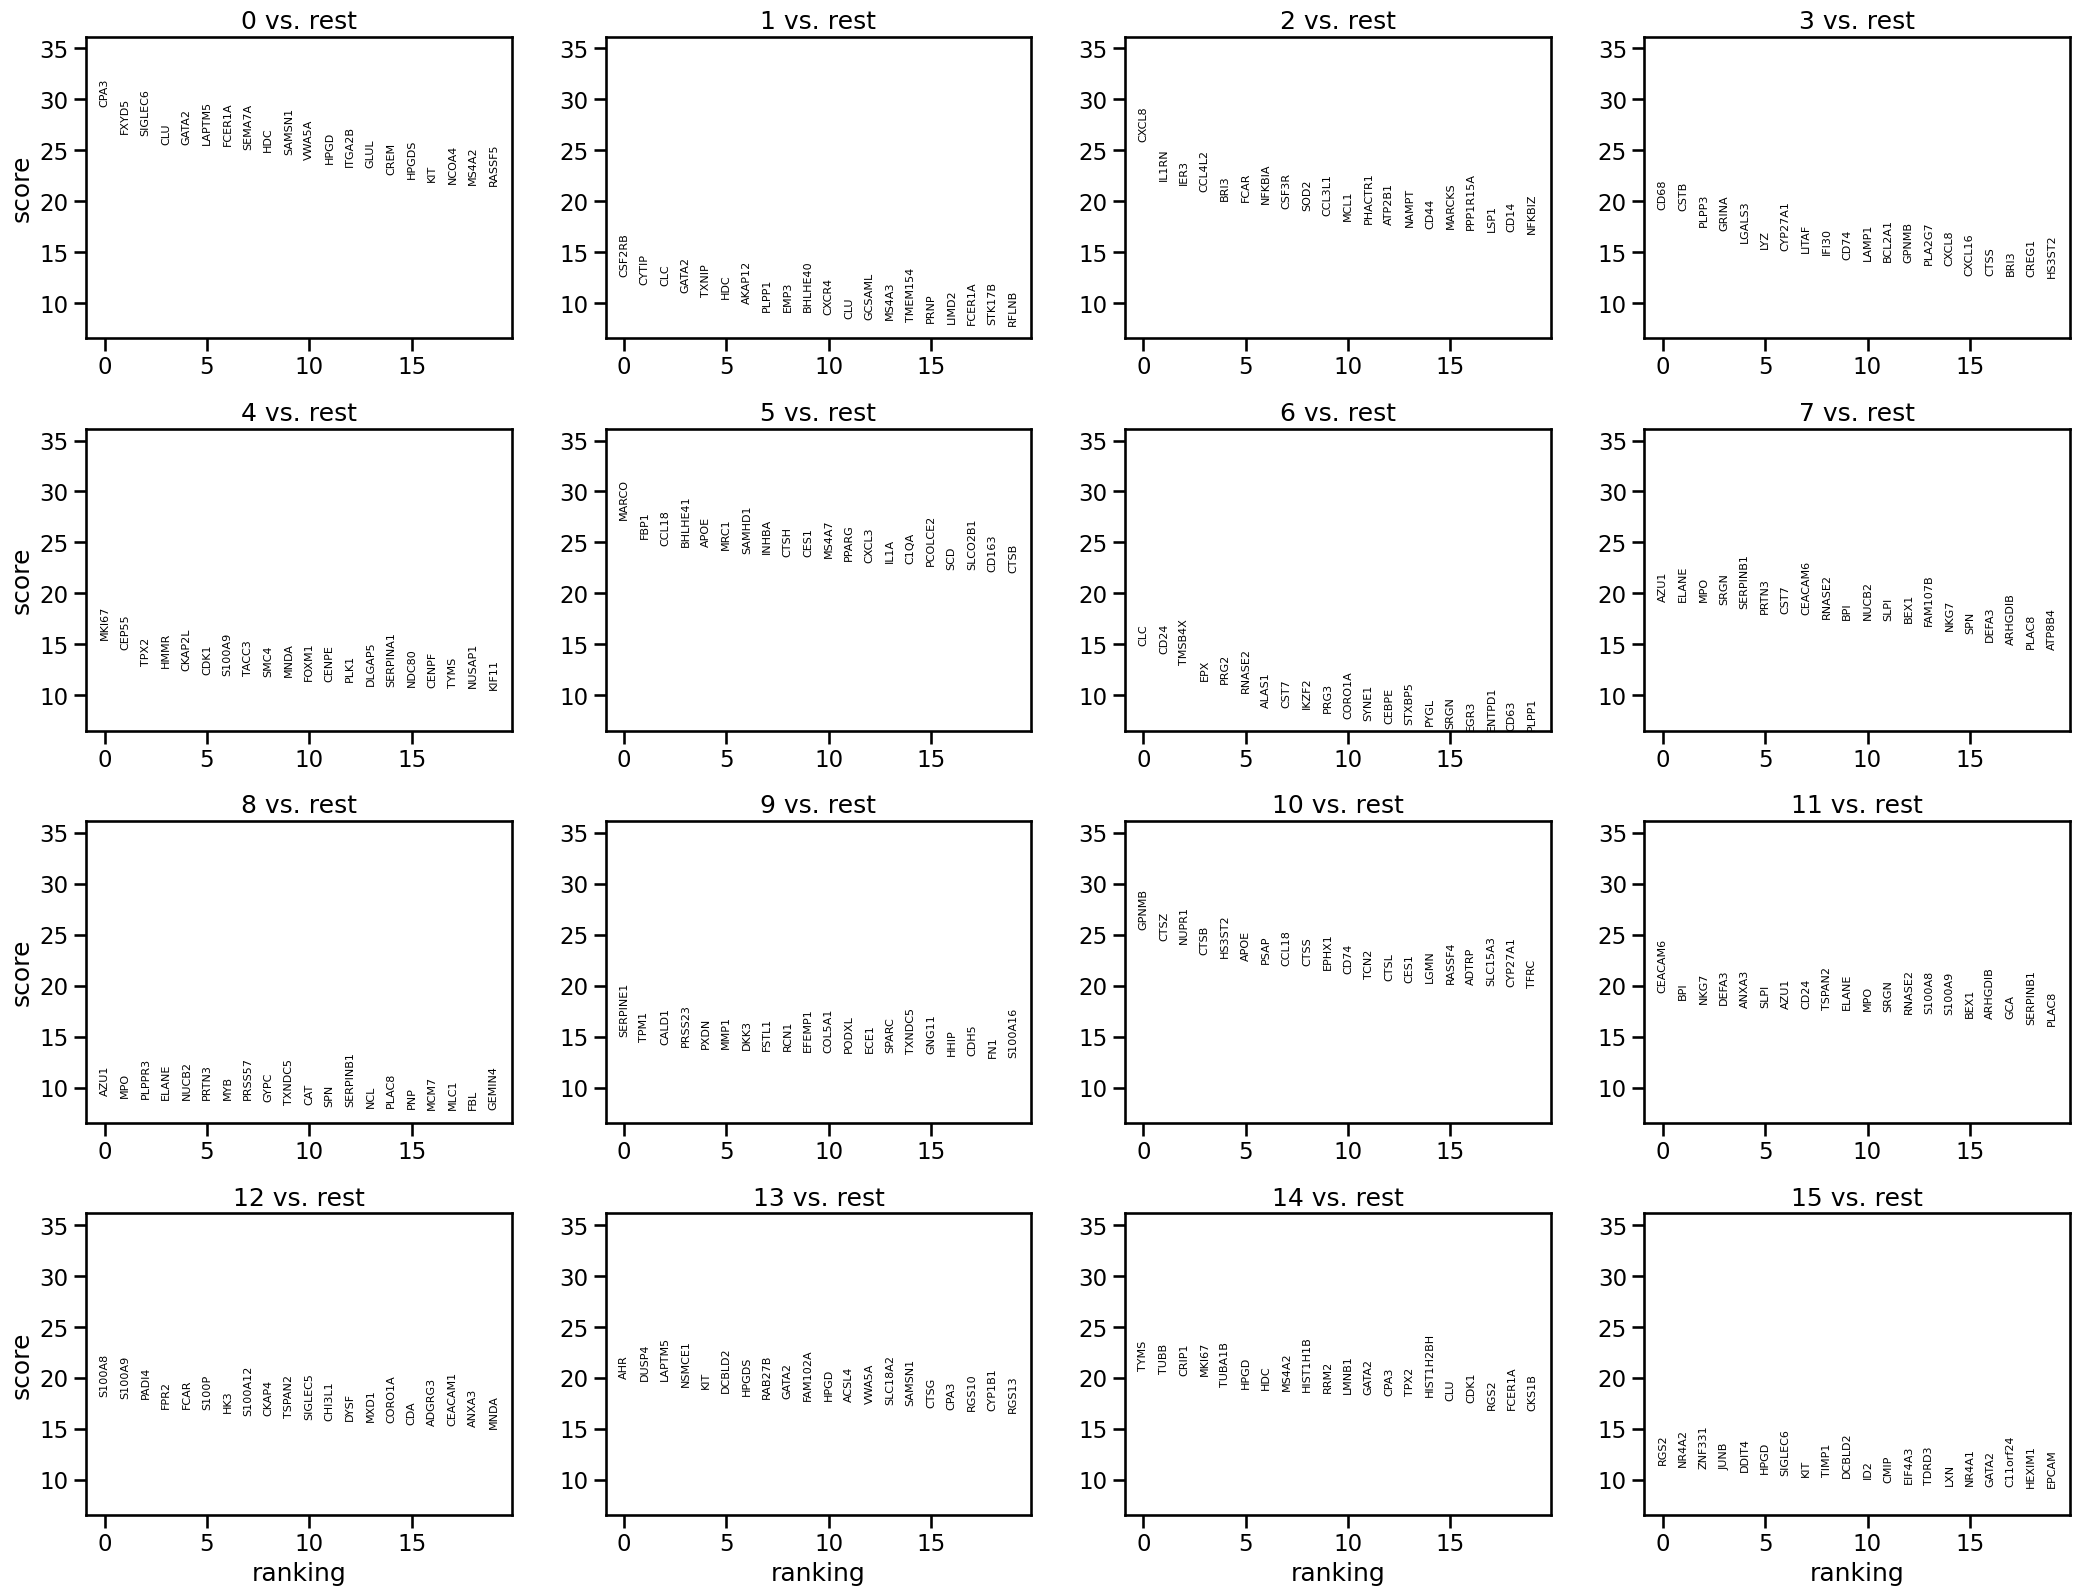

In [21]:
sc.pl.rank_genes_groups(
    adata
)

# PAGA trajectory

In [ ]:
pos = pd.DataFrame(adata.obsm["X_umap"], index=adata.obs_names)
pos["group"] = adata.obs[adata.uns["paga"]["groups"]]
pos = pos.groupby("group", observed=True).mean()

ax = sc.pl.umap(
    adata,
    show=False,
    title='All Organoids PAGA Trajectory'
)

sc.pl.paga(
    adata,
    color='leiden_1_1',
    threshold=0.1,
    node_size_scale=1,
    edge_width_scale=0.7,
    pos=pos.values,
    random_state=0,
    ax=ax
)